# Advanced Course in ML: Exercise Set 3

## Adaboost implementation

In [1]:
import sys
import numpy as np

class LDA:
	def fit(self, X, y, w):
		"""
		Fits weights (self.w) and bias (self.b) for the variant of LDA classifier.

		Parameters
		----------
		X : an array of size (n, k)
			training input data for the classifier
		y : an array of size n
			training labels for the classifier, elements must be 1 or -1
		w : an array of size n
			weights for the data points
		"""

		C = np.linalg.inv(np.cov(X.T, aweights=w) + 0.001*np.eye(X.shape[1])) # add diagonal matrix to deal with singular matrices
		ind0 = y == -1
		ind1 = y == 1
		m0 = np.sum(X[ind0, :] * w[ind0, np.newaxis], axis=0) / np.sum(w[ind0])
		m1 = np.sum(X[ind1, :] * w[ind1, np.newaxis], axis=0) / np.sum(w[ind1])

		self.w = C @ (m1 - m0)
		self.b = self.find_threshold(X, y, w)
		if self.b == None:
			self.w = -self.w
			self.b = self.find_threshold(X, y, w)

	
	def find_threshold(self, X, y, w):
		""" 
		Helper function for finding the optimal bias given the weight.

		Parameters
		----------
		X : an array of size (n, k)
			training input data for the classifier
		y : an array of size n
			training labels for the classifier, elements must be 1 or -1
		w : an array of size n
			weights for the data points

		Returns
		-------
		bias: int
			optimal bias
		"""

		score = X @ self.w
		ind = np.argsort(score)

		err = np.cumsum(y[ind]*w[ind])
		i = np.argmin(err)
		if i == len(err) - 1:
			return None
		return (score[ind[i]] + score[ind[i + 1]]) / 2


	def predict(self, X):
		""" 
		Classifies data points in X.

		Parameters
		----------
		X : an array of size (n, k)
			input data for the classifier

		Returns
		-------
		y : an array of size n
			prediction for the n data points, either -1 or 1
		"""

		return np.sign(X @ self.w - self.b) 



def adaboost(X, y, itercnt):
	""" 
	Adaboost algorithm

	Parameters
	----------
	X : an array of size (n, k)
		training input data for the classifier
	y : an array of size n
		training labels for the classifier, elements must be 1 or -1
	itercnt : int
		number of iterations

	Returns
	-------
	output : an array of size n
		ith element = weighted total vote for the (i + 1)th data point
	err_individual : an array of size itercnt
		ith element = weighted misclassification error of the (i + 1)th
		individual classifier
	err_ensemble : an array of size itercnt
		ith element = misclassification error of the ensemble after i + 1
		iterations
	err_exponential : an array of size itercnt
		ith element = exponential loss of the ensemble after i + 1 iterations
	"""

	n, k = X.shape

	err_individual = np.zeros(itercnt)
	err_ensemble = np.zeros(itercnt)
	err_exponential = np.zeros(itercnt)
	output = np.zeros(n)
	
	w = np.ones(n)/n
	betas = np.zeros((itercnt, 1))
	preds_history = np.zeros((itercnt, n))

	for i in range(itercnt):
		f_m = LDA()
		f_m.fit(X, y, w)
		preds_history[i] = f_m.predict(X)
		err_individual[i] = np.sum(w*(y != preds_history[i]))/np.sum(w)
		betas[i] = 0.5*np.log((1-err_individual[i])/err_individual[i])
		w = w*np.exp(-betas[i] * y * preds_history[i])
		output = np.sum(betas[:i+1]*preds_history[:i+1], axis=0)
		err_ensemble[i] = np.average( np.sign(output) != y )
		err_exponential[i] = np.average(np.exp(-y*output))
	
	return output, err_individual, err_ensemble, err_exponential


## Exercise 4

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (15, 15)
font = {'size'   : 12}
plt.rc('font', **font)

D = np.loadtxt("toy.txt")
labels = D[:,0].copy() # copy is needed, otherwise next line will mess up the splice
D[:,0] = 1 # replace the label column of D with constant, now the first feature gives us the bias term

itercnt = int(100)
cnt_vals = np.arange(1, itercnt+1)

output, err_individual, err_ensemble, err_exponential = adaboost(D, labels, itercnt)

### Individual Error

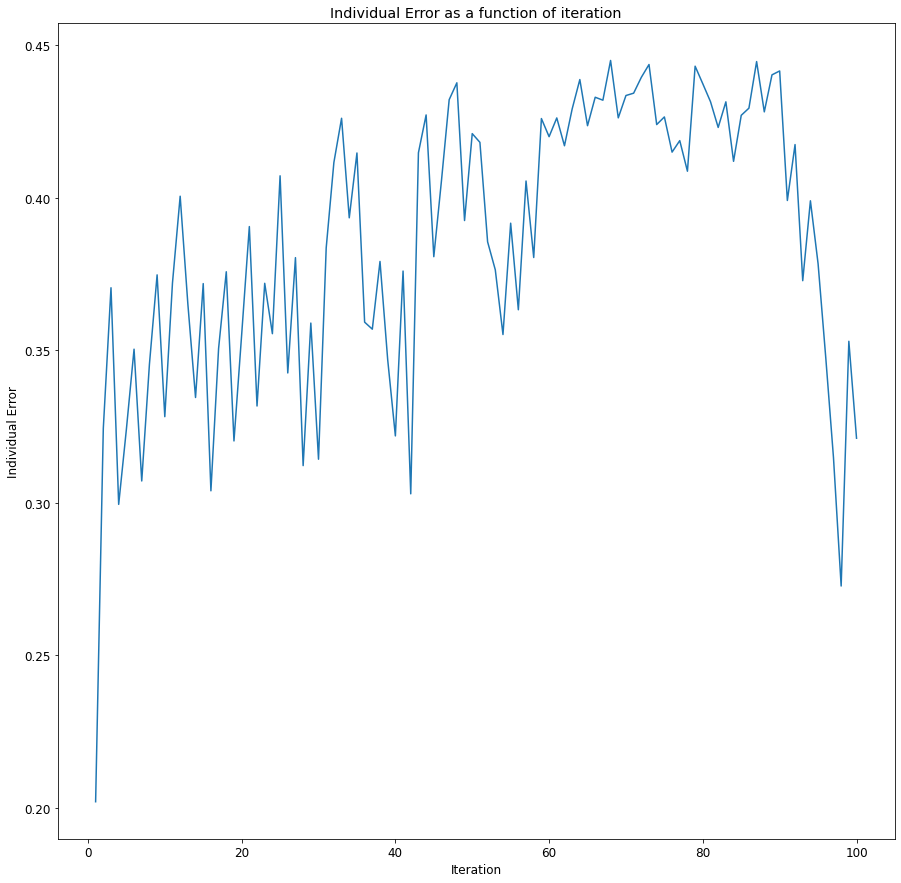

In [3]:
plt.plot(cnt_vals, err_individual)
plt.xlabel("Iteration")
plt.ylabel("Individual Error")
plt.title("Individual Error as a function of iteration")
plt.show()

We can see that the individual error oscillates up and down quite a bit, holding pretty much no correlation to the iteration number. This is due to the fact that we're measuring the error of a given iteration's *single* classifier. Each individual classifier is a *weak* learner with high bias, so the error of each model will be inherently high. Additionally, the idea of boosting is to use previous classifiers to explore different aspects of the data, which means that each of these high bias classifiers may be better at identifying differences in certain features of the data, but worse at the others; this can explain the fact that the individual classifier error seems to hold no correlation to the iteration number.

### Ensemble Error

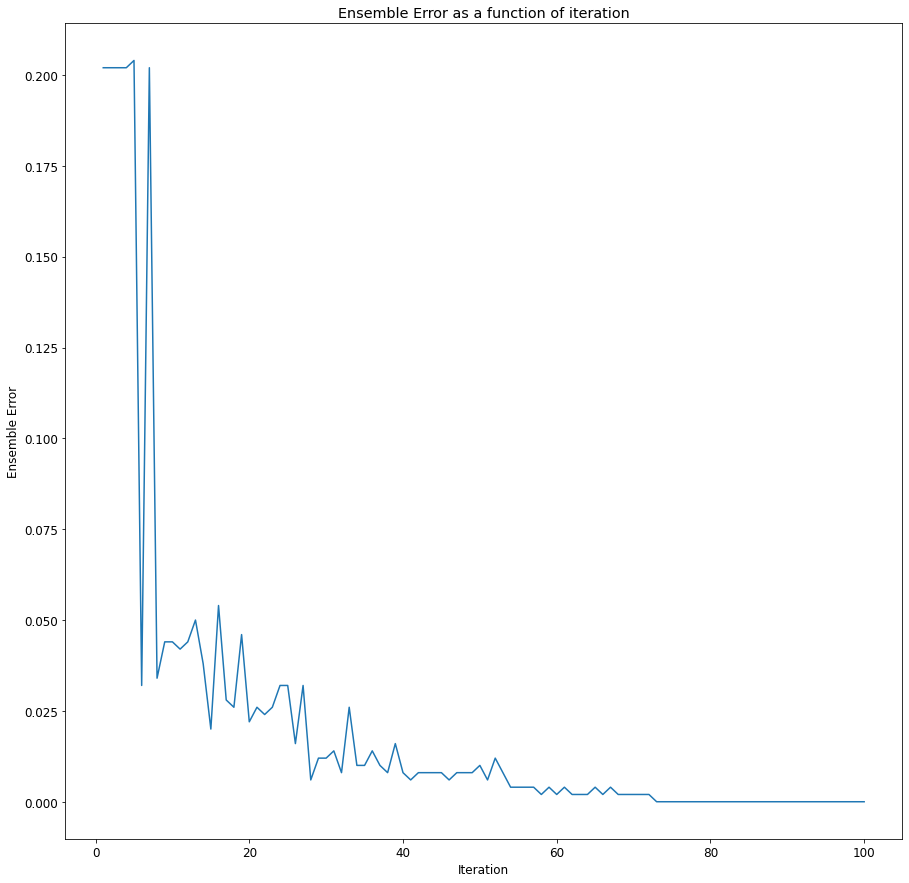

In [4]:
plt.plot(cnt_vals, err_ensemble)
plt.xlabel("Iteration")
plt.ylabel("Ensemble Error")
plt.title("Ensemble Error as a function of iteration")
plt.show()

In [5]:
print(err_ensemble)

[0.202 0.202 0.202 0.202 0.204 0.032 0.202 0.034 0.044 0.044 0.042 0.044
 0.05  0.038 0.02  0.054 0.028 0.026 0.046 0.022 0.026 0.024 0.026 0.032
 0.032 0.016 0.032 0.006 0.012 0.012 0.014 0.008 0.026 0.01  0.01  0.014
 0.01  0.008 0.016 0.008 0.006 0.008 0.008 0.008 0.008 0.006 0.008 0.008
 0.008 0.01  0.006 0.012 0.008 0.004 0.004 0.004 0.004 0.002 0.004 0.002
 0.004 0.002 0.002 0.002 0.004 0.002 0.004 0.002 0.002 0.002 0.002 0.002
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]


We can see that at the first few iterations the ensemble error is pretty high, which is expected because we have just a few classifiers on the ensemble. However, we can see that around 10 iterations we get a significant drop in the ensemble error. This can be due to the ensemble finally having enough classifiers to be able to distinguish many meaningful features in the data, thanks to the contribution of many weak classifiers that are good at simpler cases each. We can see that eventually we get enough weak classifiers to acctually be able to discern the training set perfectly, achieving a 0% ensemble error rate. AdaBoost is well known for being strong against overfitting, but it's not completely immune, especially if we deal with noisy data. Hence, this could be a case of overfitting. To reason a bit more about this, we can take a look at the data's structure:

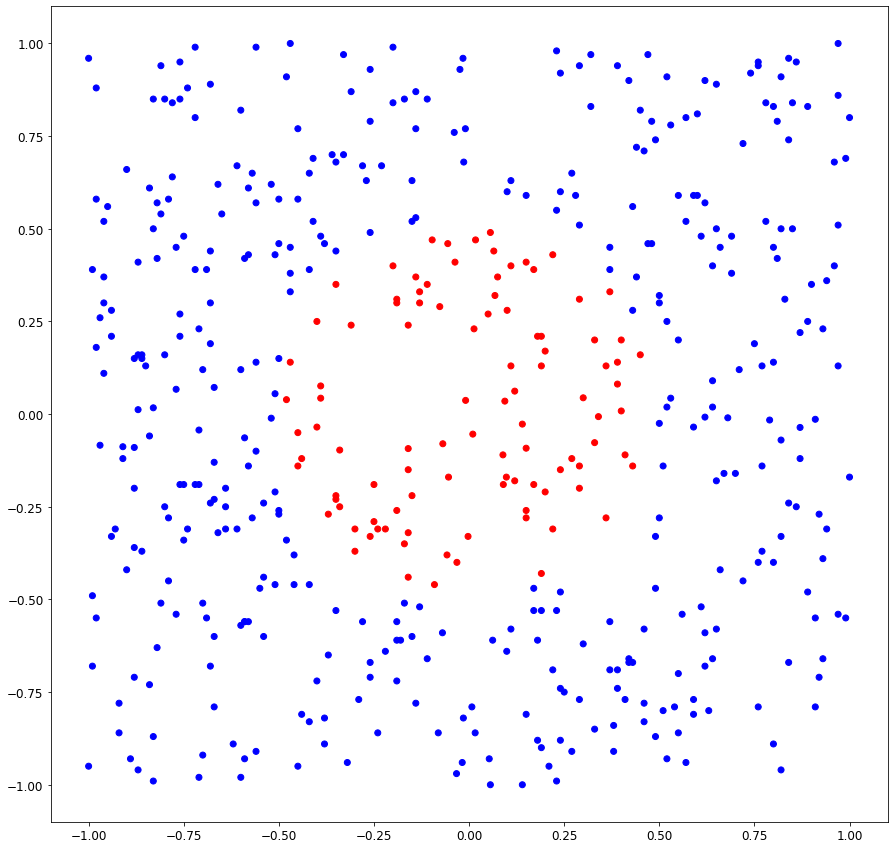

In [6]:
colors = {-1: "red",
         1: "blue"}

plt.scatter(D[:,1], D[:,2], c=[colors[label] for label in labels])
plt.show()

The decision boundary is close to a circle, though there may be a bit of noise at the boundary. Since we are using LDA, we are approximating a circle with lines, so this may be sensible to noise, and it may result in a fair bit of misclassifications at the boundary. Currently I don't know how to plot the decision boundary that we trained so that it looks nice (without lines going over all the plot),but this is indicative that the the Adaboost classifier *may* be producing an overfit on the decision boundary, especially if we keep training it after reaching 0 error (for example in the lower part of the circle there are some dents, and the classifier could "learn" those dents). This would be overfitting on our training set, so we should keep this in mind when dealing with noisy data. A "hand-drawn" example illustration of a possible overfit decision boundary could look as follows:

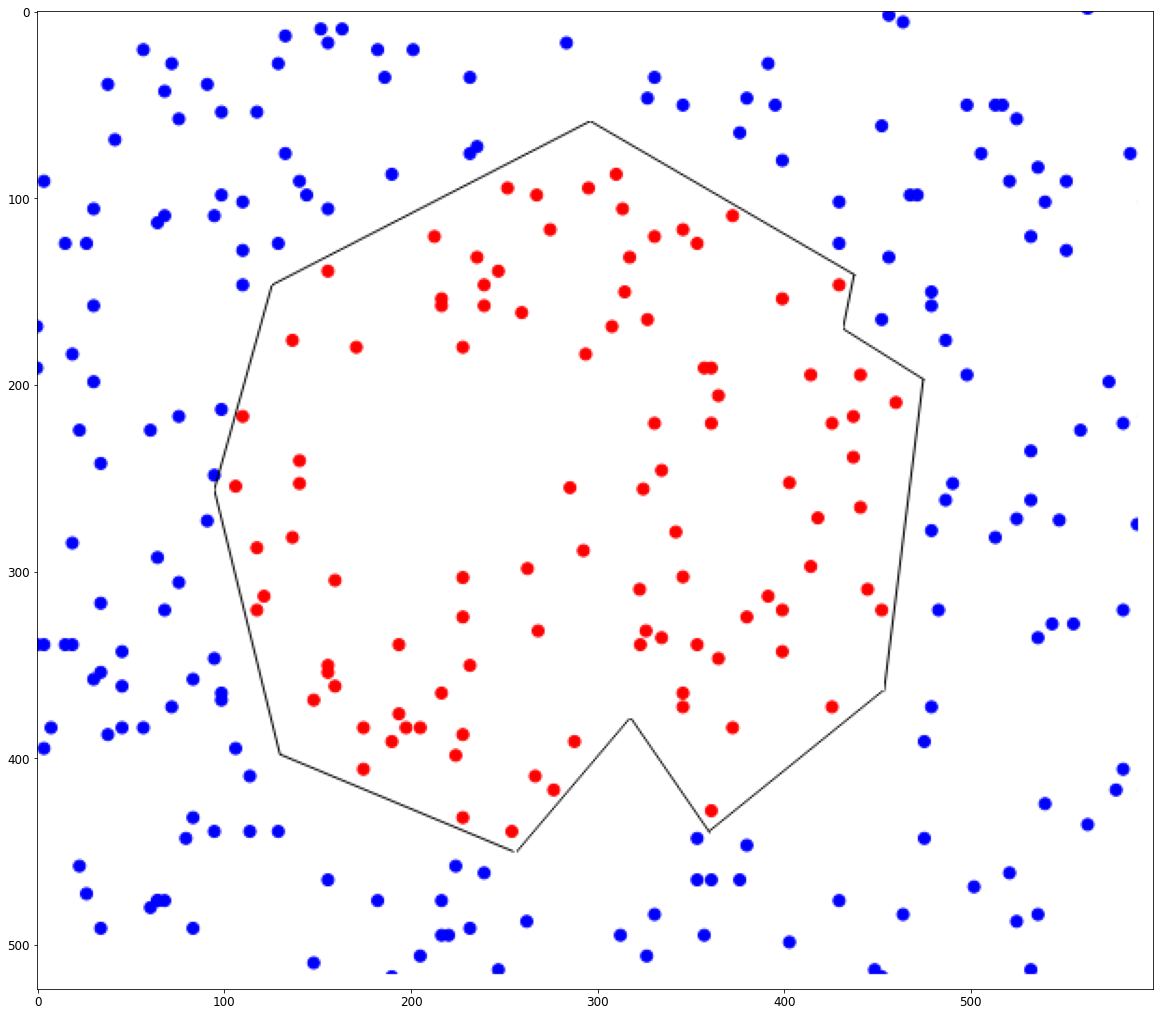

In [7]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Function to introduce the mathematical derivations
def show_img(path):
    img = mpimg.imread(path)

    plt.figure(figsize = (20,20))
    plt.imshow(img)
    return

show_img("possible_overfit_illustration.png")

Hence, it may be hard to determine if the model actually *isn't* overfitting without a separate validation set.

### Exponential Error

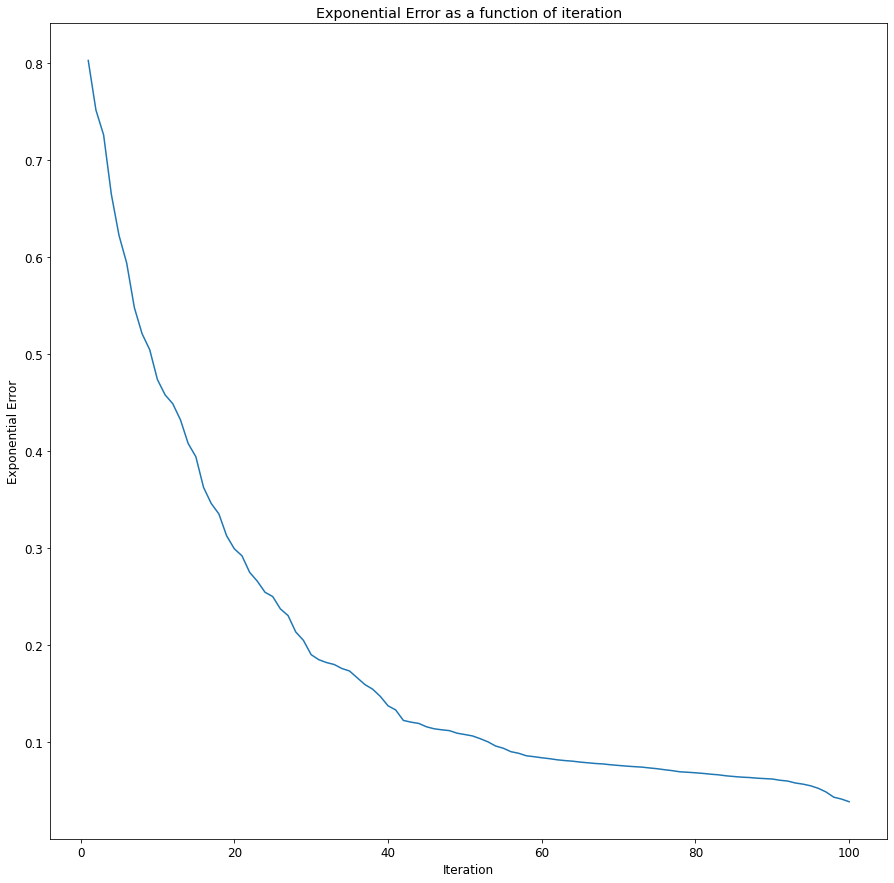

In [8]:
plt.plot(cnt_vals, err_exponential)
plt.xlabel("Iteration")
plt.ylabel("Exponential Error")
plt.title("Exponential Error as a function of iteration")
plt.show()

In [9]:
print(err_exponential)

[0.80298443 0.75185718 0.72622161 0.66528463 0.62273494 0.59420904
 0.54825038 0.52139876 0.5047809  0.47407443 0.45830934 0.44915511
 0.43253365 0.40817046 0.39454961 0.36295923 0.3463871  0.33552945
 0.31311383 0.29968488 0.29242454 0.27537555 0.26619999 0.25483876
 0.25041651 0.23768646 0.23078936 0.21389549 0.2052103  0.19053559
 0.18530285 0.18238592 0.18038434 0.17624354 0.1736624  0.16664107
 0.15967741 0.15494497 0.14751022 0.13784227 0.13353795 0.12273303
 0.12093891 0.11965081 0.11619709 0.11411346 0.11306012 0.11218064
 0.10956158 0.10818857 0.10673195 0.10390139 0.10067832 0.09636452
 0.09407773 0.09049517 0.08886597 0.08628911 0.08533969 0.08424278
 0.08332097 0.0821681  0.0813392  0.08072799 0.07978228 0.07906322
 0.07832978 0.07785588 0.07700456 0.07632227 0.07566163 0.07510662
 0.0746299  0.07376422 0.07296433 0.07190291 0.07094826 0.06975701
 0.06930548 0.06876066 0.06811364 0.06730363 0.06666931 0.06562883
 0.06492748 0.06427775 0.06388371 0.06322215 0.06277085 0.0623

The exponential error, which is the normalized exponential loss, sees a monotonic downward trend w.r.t. iteration number. This just means that the boosting model has a very high confidence discerning the datapoints in our training set, seeing as the loss goes even under 0.1. However, this could also mean that the model is overfitting, since we don't have a separate validation set to verify that the decision boundary formed by our adaboost classifier actually solves the true classification problem.

### Scatter Plot at the given amount of iterations

I draw the scatter plots where the X axis is the number of the datapoint in the training set. The original data is actually a y-label in the set ${-1, 1}$ and the datapoints are 2-dimensional points, and plotting this on a 3-dimensional scatter plot can get cluttered very quickly.

To show the predicted labels, we can use the sign function, because the output of Adaboost (the votes) are not necessarily bounded within the set ${-1,1}$. To show the misclassifications, we can draw a vertical line between the prediction and the true label; this way, there will be a line when there is a misclassification, and no lines for a good classification. The results for the asked iterations are shown below:

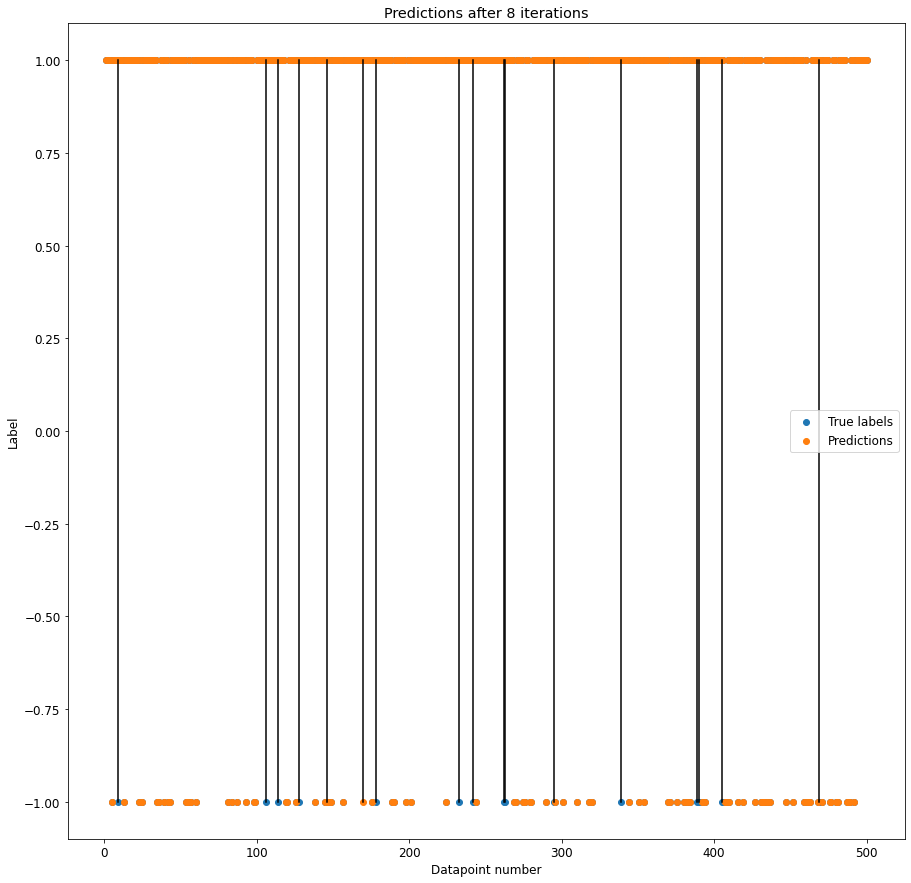

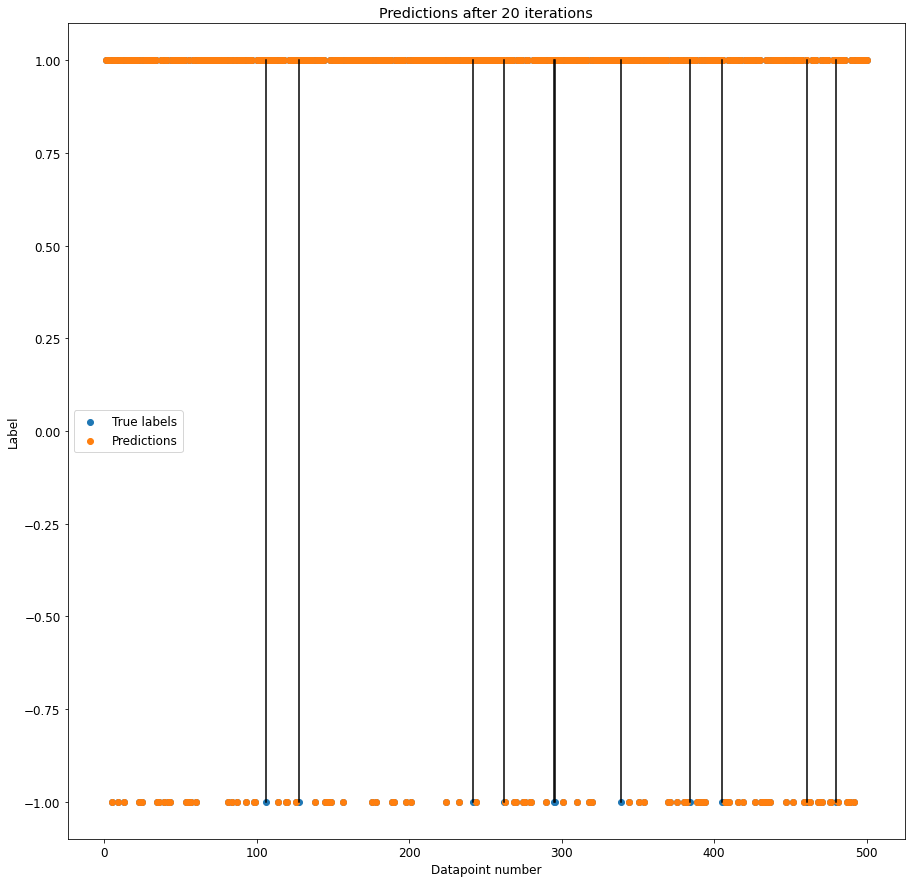

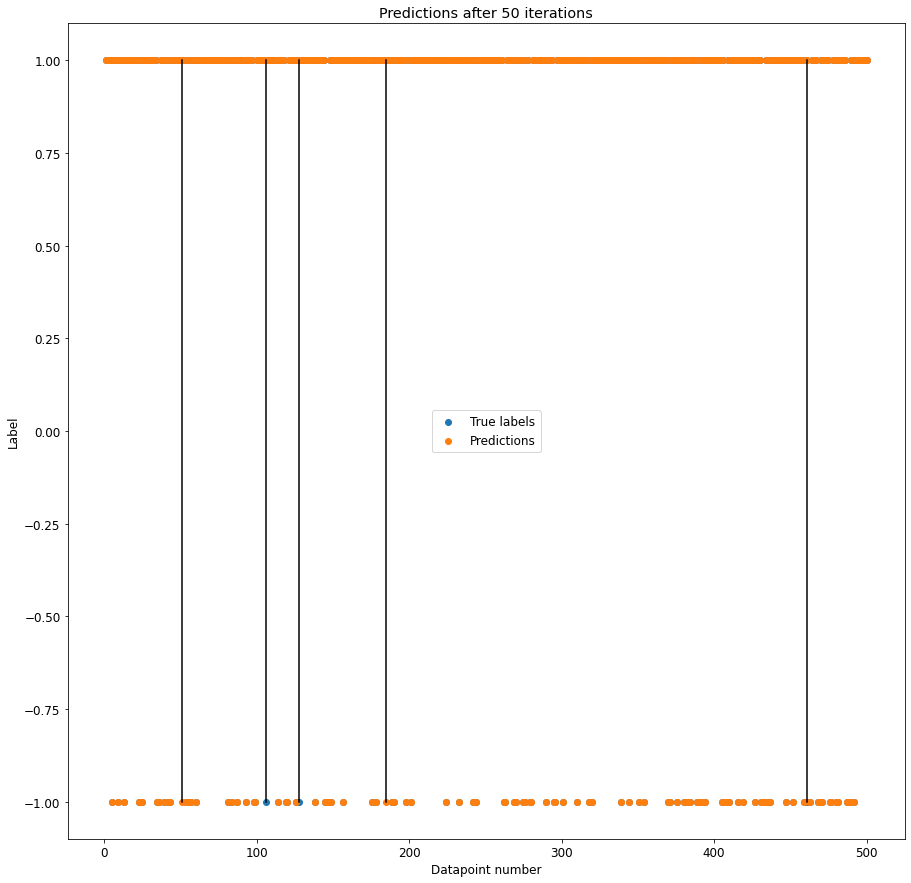

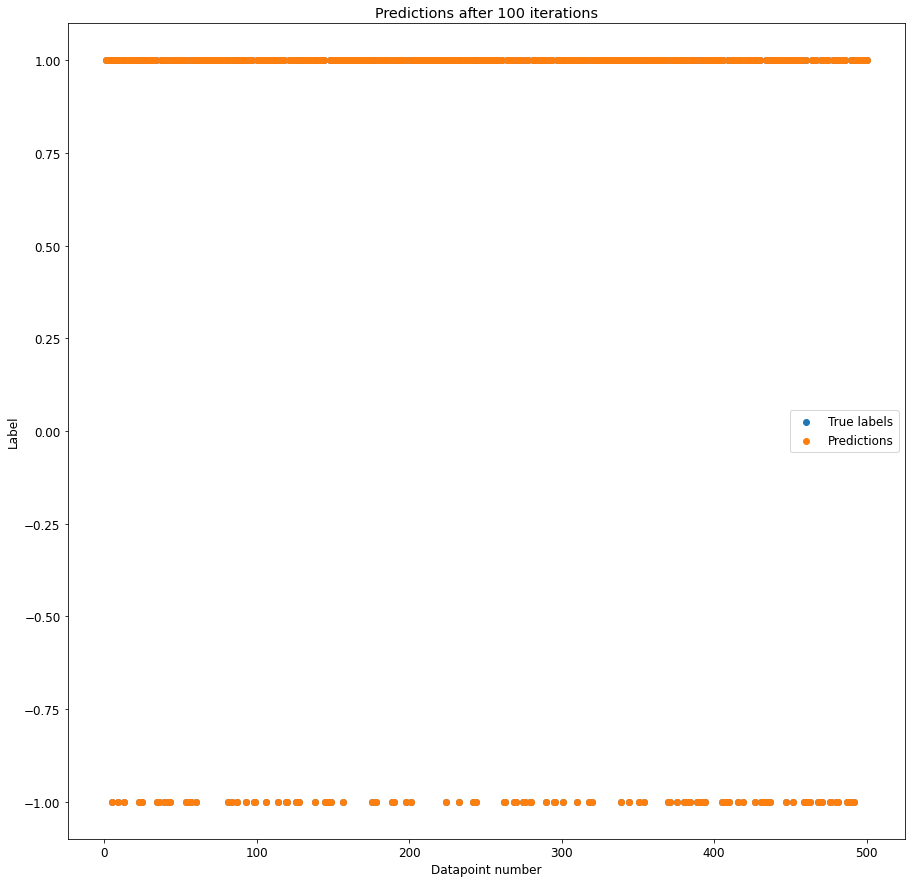

In [10]:
iters = [8, 20, 50, 100]
n = D.shape[0]
plot_x = np.arange(1, n+1)
for amount in iters:
    out_iter, _, _, _ = adaboost(D, labels, amount)
    preds = np.sign(out_iter) # Predicted labels
    plt.scatter(plot_x, labels, label="True labels")
    plt.scatter(plot_x, preds, label="Predictions")
    plt.plot((plot_x, plot_x),([i for (i, j) in zip(preds, labels)], [j for (i,j) in zip(preds, labels)]),c='black') # To draw a vertical line on misclassifications
    plt.xlabel("Datapoint number")
    plt.ylabel("Label")
    plt.title(f"Predictions after {amount} iterations")
    plt.legend()
    plt.show()

We can see that at the beginning, Adaboost is producing a significant amount of misclassifications, but as the amount of iterations goes up, the misclassifications go down, eventually reaching 0 at 100 iterations. Again, this could be a sign of overfitting with a big amount of classifiers, but without a separate validation set this is hard to tell. We can also visualize the unnormalized outputs of Adaboost in scatterplots to see how each datapoint's classification evolves over time:

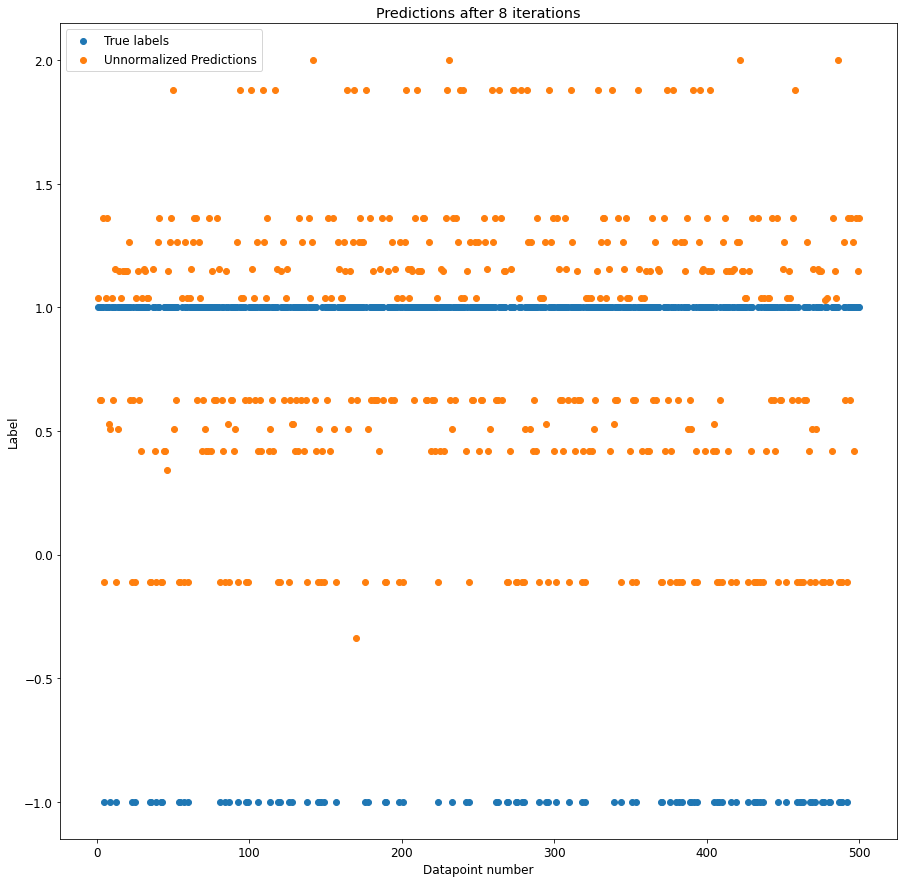

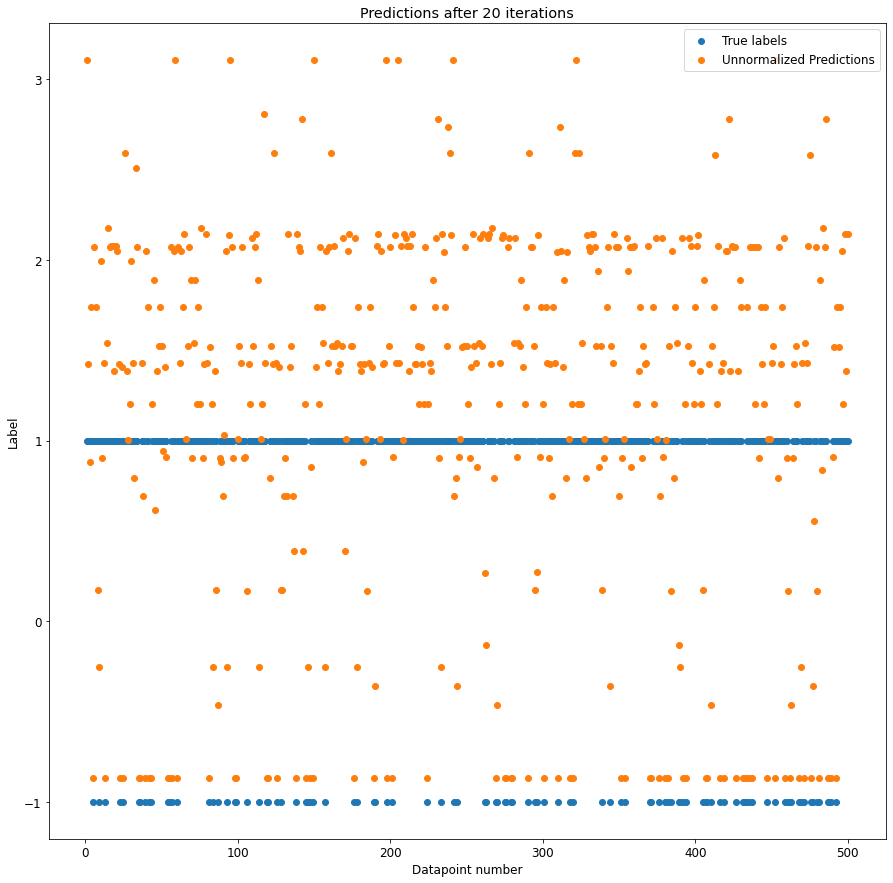

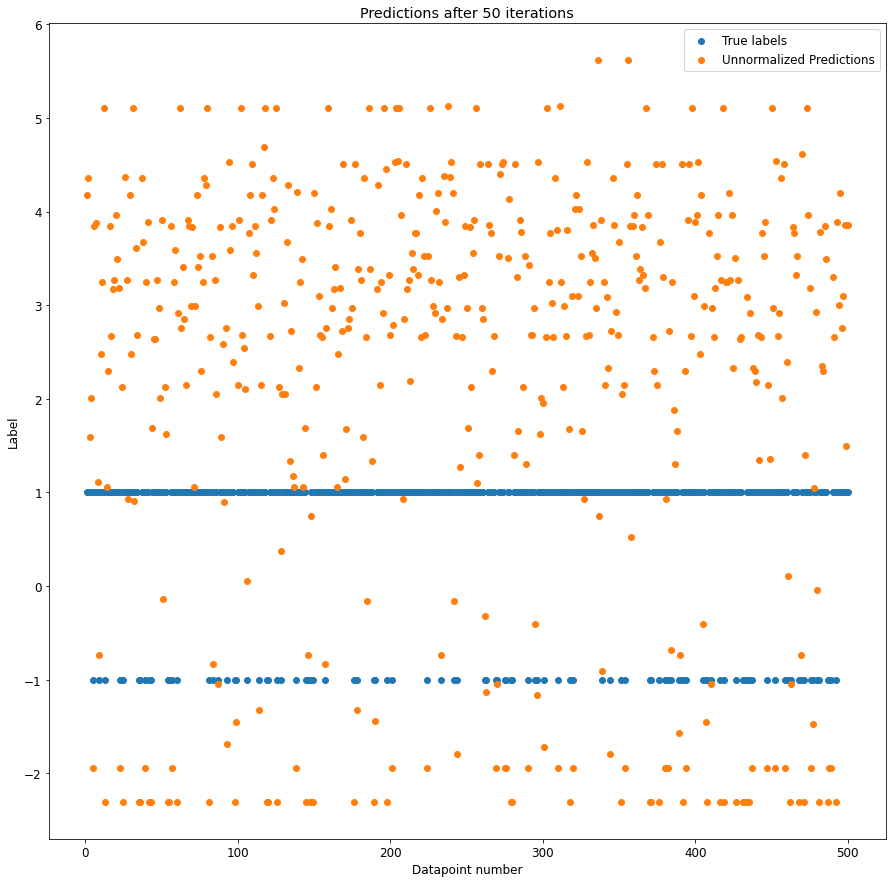

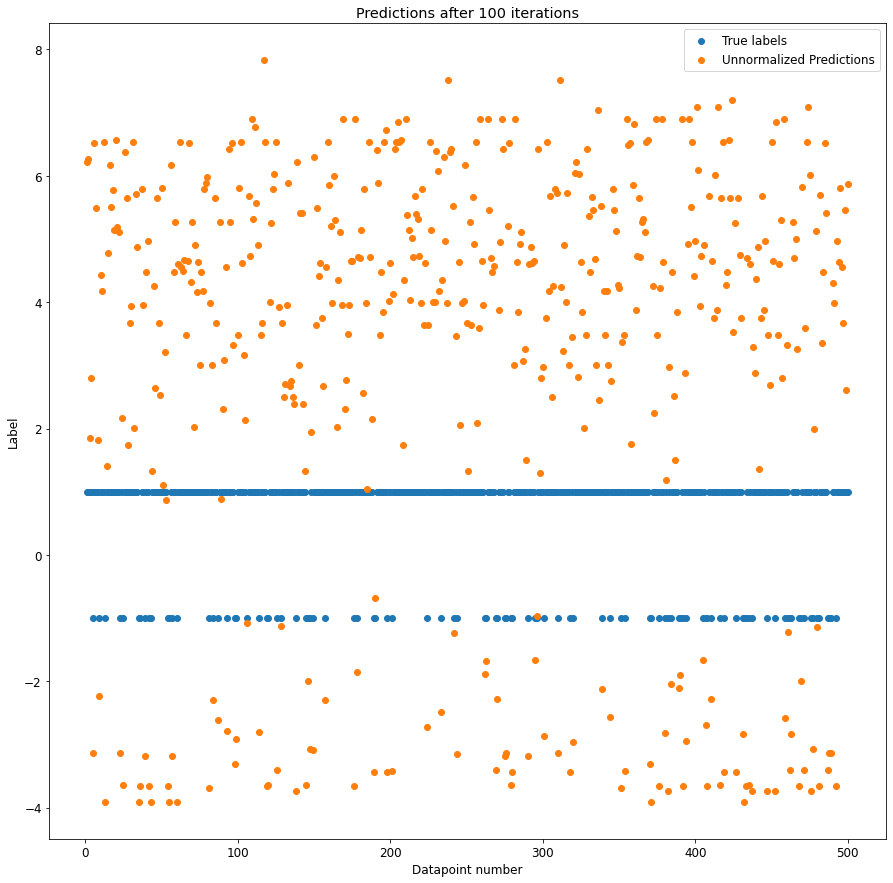

In [11]:
for amount in iters:
    out_iter, _, _, _ = adaboost(D, labels, amount)
    plt.scatter(plot_x, labels, label="True labels")
    plt.scatter(plot_x, out_iter, label="Unnormalized Predictions")
    plt.xlabel("Datapoint number")
    plt.ylabel("Label")
    plt.title(f"Predictions after {amount} iterations")
    plt.legend()
    plt.show()

Here, we can see that at the beginning there is a good amount of uncertainty since a lot of the datapoints' labels reside between -1 and 1. However, as the iterations go up, we start seeing a lot of the points getting *very* high confidence in classification (which is seen by the magnitude of the unnormalized prediction). There are very few points that reside between -1 and 1 by 100 iterations, showcasing that the classifier has learned our training set with very high confidence.